[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bgoujaud/PEPit/blob/master/ressources/demo/PEPit_demo.ipynb)

# PEPit : numerical examples of worst-case analyses

This notebook provides:
- a simple example illustrating how to obtain a worst-case guarantee for **gradient descent** using the PEPit package,
- worst-case analyses for 4 more advanced examples, for which we compare analytical and numerical worst-case guarantees, respectively obtained in the literature and by PEPit.  

In short, PEPit is a package enabling **computer-assisted worst-case analyses** of first-order optimization methods. The key underlying idea is to cast the problem of performing a worst-case analysis, often referred to as a performance estimation problem (PEP), as a semidefinite program (SDP) which can be solved numerically. For doing that, the package users are only required to write first-order methods nearly as they would have implemented them. The package then takes care of the SDP modelling parts, and the worst-case analysis is performed numerically via a standard solver.


PEPit can be installed following these [instructions](https://pypi.org/project/PEPit/), and a quickstart is available in its [documentation](https://pepit.readthedocs.io/en/latest/). More information can be found in the [PEPit reference paper](https://arxiv.org/pdf/2201.04040.pdf). 

We refer to [this blog post](https://francisbach.com/computer-aided-analyses/) and the references therein for a more mathematical introduction to performance estimation problems.

<a id="toc"></a>
## Table of Contents
- [1 Installing PEPit](#1-Installing-PEPit)
- [2 How to obtain a worst-case guarantee for GD using PEPit](#2-How-to-obtain-a-worst-case-guarantee-for-GD-using-PEPit)
    - [2.1 Imports](#2.1-Imports)
    - [2.2 Initialization of PEPit](#2.2-Initialization-of-PEPit)
    - [2.3 Choose parameters values](#2.3-Choose-parameters-values)
    - [2.4 Specifying the problem class](#2.4-Specifying-the-problem-class)
    - [2.5 Algorithm initialization](#2.5-Algorithm-initialization)
    - [2.6 Algorithm implementation](#2.6-Algorithm-implementation)
    - [2.7 Setting up a performance measure](#2.7-Setting-up-a-performance-measure)
    - [2.8 Solving the PEP](#2.8-Solving-the-PEP)
    - [2.9 Analytical upper bound comparison](#2.9-Comparing-to-the-an-(established)-analytical-upper-bound-(worst-case-guarantee)-provided-by-the-literature)
    - [2.10 Conclusion](#2.10-Conclusion)
- [3 Comparison of analytical and numerical worst-case guarantees](#3-Comparison-of-analytical-(obtained-in-the-literature)-and-numerical-(obtained-by-PEPit)-worst-case-guarantees-on-4-more-advanced-methods)
    - [3.1 Example 1: GD with fixed step size](#3.1-Example-1-:-Gradient-descent-with-fixed-step-size-in-contraction)
        - [3.1.1 Worst-case guarantees as functions of the iteration count](#3.1.1-Worst-case-guarantees-as-functions-of-the-iteration-count)
        - [3.1.2 Worst-case guarantees as functions of the step size](#3.1.2-Worst-case-guarantees-as-functions-of-the-step-size)
    - [3.2 Example 2: Accelerated gradient method](#3.2-Example-2-:-An-accelerated-gradient-method-for-strongly-convex-objectives)
    - [3.3 Example 3: Accelerated Douglas-Rachford splitting](#3.3-Example-3-:-An-accelerated-Douglas-Rachford-splitting)
    - [3.4 Example 4: point-SAGA](#3.4-Example-4-:-point-SAGA)

## 1 Installing PEPit

In [ ]:
# If PEPit is not installed yet, you can run this cell.
!pip3 install pepit;

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

## 2 How to obtain a worst-case guarantee for GD using PEPit

In this section, we provide a step-by-step tutorial on how to use PEPit to compute a worst-case guarantee for gradient descent.

That is, we consider the minimization problem

$$\min_{x} f(x),$$

where $f$ os an $L$-smooth convex function which is minimized at $x_*$. We denote by $x_n$ the output of gradient descent with step-size $\gamma$ after $n\in\mathbb{N}$ iterations, starting from $x_0$. We perform a worst-case analysis in the following sense: we compute the smallest possible value of $\tau(L,\gamma,n)$ such that

$$ f(x_{n})-f(x_*) \leqslant\  \tau(L,\gamma,n)\  \  \|x_0-x_*\|^2_2$$

is valid for all $L$-smooth convex function $f$ and initial iterate $x_0$. Computing the smallest possible such $\tau(L,\gamma,n)$ is equivalent to computing the worst-case value of $f(x_{n})-f(x_*)$ under the constraint $\| x_{0}-x_*\|_2^2\leqslant 1$.

PEPit formulates the problem of computing $\tau(L,\gamma,n)$ as an SDP which can be solved numerically. In what follows, we describe the few lines that a user has to provide for generating the numerical worst-case analysis of GD using PEPit.

In general, performing a worst-case analysis of a first-order method usually relies on **four main ingredients**: 
- <font color='blue'>a class of problems</font> (containing the assumptions on the function to be minimized),
- <font color='red'>a first-order method</font> (to be analyzed), 
- <font color='purple'>a performance measure</font> (measuring the quality of the output of the algorithm under consideration),
- <font color='green'>an initial condition</font> (measuring the quality of the initial iterate). 

PEPit requires the user to specify a choice for each of those four elements.

### 2.1 Imports
Before anything else, we have to import the PEP and the classes of functions of interest.

In [1]:
from PEPit import PEP
from PEPit.functions import SmoothStronglyConvexFunction

### 2.2 Initialization of PEPit
Then, we initialize a PEP object. This object allows manipulating the forthcoming ingredients of the PEP, such as functions and iterates.

In [2]:
# Instantiate PEP
problem = PEP()

### 2.3 Choose parameters values

For the sake of the example, we pick some simple values for the problem class and algorithmic parameters, for which we perform the worst-case analysis below. 

In [3]:
# Specify values for the smoothness parameter L, number of iterations n, and the step size gamma.
L = 3
n = 4
gamma = 1 / L

### 2.4 Specifying the problem class
Next, we specify our assumptions on the <font color='blue'>**class of functions**</font> containing the function to be optimized, and instantiate a corresponding object. Here, we consider an $L$-smooth convex function. 

<br> <font color='grey'>*Remark*: PEPit can handle various function classes</font> [(documentation)](https://pepit.readthedocs.io/en/latest/api/functions_and_operators.html).

Note: we use the ```SmoothStronglyConvexFunction``` class with $\mu=0$ here. Alternatively, one could use ```SmoothConvexFunction```.

In [4]:
# Declare an L-smooth mu-strongly convex function named "func"
func = problem.declare_function(
                SmoothStronglyConvexFunction,
                mu=0,   # Strong convexity param.
                L=L)    # Smoothness param.

We also define $x_*$ as an optimal point and $f_*$ as the optimal value.

In [5]:
# Start by defining an optimal point xs = x_* and corresponding function value fs = f_*
xs = func.stationary_point()
fs = func(xs)

### 2.5 Algorithm initialization

Third, we can instantiate the starting points for the two gradient methods that we will run, and specify an <font color='green'>**initial condition**</font> on those points. 
To this end, a starting point $x_0$ is introduced,  and a bound on the initial distance between those points is specified as $\|x_0-x_*\|^2\leqslant 1$.

<br> <font color='grey'> *Remark*: PEPit can handle various initial constraints, for example any linear combination of $f(x_0)-f_*$, $\|x_0-x_*\|^2$ or $\|\nabla f(x_0)\|^2$.</font>


In [6]:
# Then define the starting point x0 of the algorithm
x0 = problem.set_initial_point()

# Set the initial constraint that is the distance between x0 and x^*
problem.set_initial_condition((x0 - xs) ** 2 <= 1)

### 2.6 Algorithm implementation

In this fourth step, we specify the <font color='red'>**algorithm**</font> in a natural format. In this example, we simply use the iterates (which are PEPit objects) as if we had to implement gradient descent in practice using a simple loop. Gradient descent with fixed step size $\gamma$ may be described as follows, for $t \in \{0,1, \ldots, n-1\}$
\begin{equation}
x_{t+1} = x_t - \gamma \nabla f(x_t).
\end{equation}

<br> <font color='grey'>*Remark*: PEPit can handle most first order algorithms that rely on some simple</font> [oracles.](https://pepit.readthedocs.io/en/latest/api/steps.html)<br><font color='grey'> More than 50 examples (for deterministic, stochastic, and/or composite optimization) are provided in the</font> [documentation](https://pepit.readthedocs.io/en/latest/examples.html).

In [7]:
# Run n steps of gradient descent with step-size gamma
x = x0
for _ in range(n):
    x = x - gamma * func.gradient(x)

### 2.7 Setting up a performance measure

It is crucial for the worst-case analysis to specify the <font color='purple'>**performance metric**</font> for which we wish to compute a worst-case performance. In this example, we wish to compute the worst-case value of $f(x_n)-f_*$, which we specify as follows. 

<br> <font color='grey'> *Remark*: PEPit can handle various performance metrics, for example any linear combination of $f(x_n)-f_*$, $\|x_n-x_*\|^2$ or $\|\nabla f(x_n)\|^2$.</font>


In [8]:
# Set the performance metric to the function values accuracy
problem.set_performance_metric(func(x) - fs)

### 2.8 Solving the PEP

The last natural stage in the process is to solve the corresponding PEP. This is done via the following line, which will ask PEPit to perform the modelling steps and to call an appropriate SDP solver (which should be installed beforehand) to perform the worst-case analysis.

The solver is [CVXPY](https://www.cvxpy.org/) (the default solver being [SCS](https://web.stanford.edu/~boyd/papers/scs.html) which might not be the most appropriate solvers for solving SDPs; we advise installing [MOSEK](https://www.mosek.com/) if possible, for improved numerical performances).

In [9]:
# Solve the PEP with verbose = 1
verbose = 1
pepit_tau = problem.solve(verbose=verbose)

(PEPit) Setting up the problem: size of the Gram matrix: 7x7
(PEPit) Setting up the problem: performance measure is the minimum of 1 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 1 function(s)
			Function 1 : Adding 30 scalar constraint(s) ...
			Function 1 : 30 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 0 function(s)
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: SCS); optimal value: 0.16666634632022087
(PEPit) Postprocessing: solver's output is not entirely feasible (smallest eigenvalue of the Gram matrix is: -2.6e-07 < 0).
 Small deviation from 0 may simply be due to numerical error. Big ones should be deeply investigated.
 In any case, from now the provided values of parameter

### 2.9 Comparing to the an (established) analytical upper bound (worst-case guarantee) provided by the literature

We can now compare to a **analytical value**, provided in [1, Theorem 1].  When $\gamma \leqslant \frac{1}{L}$, the analytical value for the exact worst case guarantee can be found is:
$$f(x_n)-f_* \leqslant \frac{L||x_0-x_\star||^2}{4nL\gamma+2}$$
which is achieved on some Huber loss functions.


[1] Y. Drori, M. Teboulle (2014). [Performance of first-order methods for smooth convex minimization: a novel approach](https://arxiv.org/pdf/1206.3209.pdf). Mathematical Programming 145(1–2), 451–482.


In [10]:
# Compute theoretical guarantee (for comparison)
theoretical_tau = L / (4 * n * L * gamma + 2)

# Print conclusion if required
if verbose != -1:
    print('*** Worst-case performance of gradient descent with fixed step-sizes ***')
    print('\tPEPit guarantee:\t f(x_n)-f_* <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))
    print('\tTheoretical guarantee:\t f(x_n)-f_* <= {:.6} ||x_0 - x_*||^2'.format(theoretical_tau))

*** Worst-case performance of gradient descent with fixed step-sizes ***
	PEPit guarantee:	 f(x_n)-f_* <= 0.166667 ||x_0 - x_*||^2
	Theoretical guarantee:	 f(x_n)-f_* <= 0.166667 ||x_0 - x_*||^2


### 2.10 Conclusion
For the parameters specified above, the worst-case guarantee obtained numerically by PEPit matches the analytical value of the best known (tight) worst-case guarantee.

The following code is provided as one of the 50+ examples in the package, see  [`GradientMethod`](https://pepit.readthedocs.io/en/latest/examples/a.html#gradient-descent). 

It is possible to directly re-run all the cells above using the ````wc_gradient_descent```` function.

In [11]:
from PEPit.examples.unconstrained_convex_minimization import wc_gradient_descent
pepit_tau, theoretical_tau = wc_gradient_descent(L=L, gamma=1 / L, n=4, verbose=1)

(PEPit) Setting up the problem: size of the Gram matrix: 7x7
(PEPit) Setting up the problem: performance measure is the minimum of 1 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 1 function(s)
			Function 1 : Adding 30 scalar constraint(s) ...
			Function 1 : 30 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 0 function(s)
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: SCS); optimal value: 0.16666634632022087
(PEPit) Postprocessing: solver's output is not entirely feasible (smallest eigenvalue of the Gram matrix is: -2.6e-07 < 0).
 Small deviation from 0 may simply be due to numerical error. Big ones should be deeply investigated.
 In any case, from now the provided values of parameter

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

## 3 Comparison of analytical (obtained in the literature) and numerical (obtained by PEPit) worst-case guarantees on 4 more advanced methods

In this section, we compare the worst-case guarantees obtained with PEPit and to reference worst-case guarantees for four algorithms:
- **gradient descent** with fixed step size (in terms of contraction rate),
- an **accelerated gradient** method (see for example [this ressource](https://arxiv.org/pdf/2101.09545.pdf), Algorithm 16) for strongly convex objectives,
- an **accelerated Douglas-Rachford** splitting (see [this ressource](https://arxiv.org/pdf/1407.6723.pdf), Section IV),
- **point-SAGA** (see [this ressource](https://proceedings.neurips.cc/paper/2016/file/4f6ffe13a5d75b2d6a3923922b3922e5-Paper.pdf), Algorithm 1).

The following source code also allows to reproduce the figures of the [PEPit reference paper](https://arxiv.org/pdf/2201.04040.pdf).



- [3.1 Example 1: GD with fixed step size](#3.1-Example-1-:-Gradient-descent-with-fixed-step-size-in-contraction)
    - [3.1.1 Worst-case guarantees as functions of the iteration count](#3.1.1-Worst-case-guarantees-as-functions-of-the-iteration-count)
    - [3.1.2 Worst-case guarantees as functions of the step size](#3.1.2-Worst-case-guarantees-as-functions-of-the-step-size)
- [3.2 Example 2: Accelerated gradient method](#3.2-Example-2-:-An-accelerated-gradient-method-for-strongly-convex-objectives)
- [3.3 Example 3: Accelerated Douglas-Rachford splitting](#3.3-Example-3-:-An-accelerated-Douglas-Rachford-splitting)
- [3.4 Example 4: point-SAGA](#3.4-Example-4-:-point-SAGA)

**Instead  of re-implementing the methods as in Section 2 above, we directly import the corresponding examples and Python common packages (numpy, matplotlib) and PEPit.**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import PEPit

# import gradient descent in contraction from the toolbox
from PEPit.examples.tutorials import wc_gradient_descent_contraction
# import an accelerated gradient method for the strongly convex objectives from the toolbox 
from PEPit.examples.unconstrained_convex_minimization import wc_accelerated_gradient_strongly_convex
# import an accelerated Douglas Rachford splitting from the toolbox
from PEPit.examples.composite_convex_minimization import wc_accelerated_douglas_rachford_splitting
# import point-SAGA from the toolbox
from PEPit.examples.stochastic_and_randomized_convex_minimization import wc_point_saga

In [13]:
# Set the verbose parameter to 0 to only print the result without details
# and to -1 to return worst-case without printing a detailed report.
verbose = -1

### 3.1 Example 1 : Gradient descent with fixed step size in contraction<a class="anchor" id="example1"></a>

We consider the following convex minimization problem:
\begin{equation}
f_\star \triangleq \min_x f(x),
\end{equation}
where $f$ is $L$-smooth and $\mu$-strongly convex.

The package PEPit allows to compute a worst-case guarantee for **gradient descent** with fixed step size $\gamma$. That is, it computes the smallest possible $\tau(n, L, \mu, \gamma)$ such that the following guarantee holds (for all initialization of the algorithm, and all $L$-smooth $\mu$-strongly convex function)
\begin{equation}
\| x_n - y_n \|^2 \leqslant \tau(n, L, \mu, \gamma) \| x_0 - y_0 \|^2,
\end{equation}
where $x_n$ and $y_n$ are the outputs of the gradient descent with fixed step size $\gamma$, starting respectively from $x_0$ and $y_0$.

#### Algorithm

Gradient descent with fixed step size $\gamma$ may be described as follows, for $t \in \{0,1, \ldots, n-1\}$
\begin{equation}
x_{t+1} = x_t - \gamma \nabla f(x_t).
\end{equation}

#### Theoretical guarantee

The **tight** worst-case guarantee which we compare to below, is 
\begin{equation}
\| x_n - y_n \|^2 \leqslant \max\left\{(1-L\gamma)^2,(1-\mu \gamma)^2\right\}^n\| x_0 - y_0 \|^2,
\end{equation}
which is tight on simple quadratic functions.

#### 3.1.1 Worst-case guarantees as functions of the iteration count

In [14]:
# Set the parameters
L = 1          # smoothness parameter
mu = 0.1       # strong convexity parameter
gamma = 1 / L  # step-size

# Set a list of iteration counter to test
n_list = np.array([1, 2, 4, 6, 8, 10, 15])


# Compute numerical and theoretical (analytical) worst-case guarantees for each iteration count
pepit_taus = list()
theoretical_taus = list()
for n in n_list:
    pepit_tau, theoretical_tau = wc_gradient_descent_contraction(mu=mu,
                                                                 L=L,
                                                                 gamma=gamma,
                                                                 n=n,
                                                                 verbose=verbose,
                                                                )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

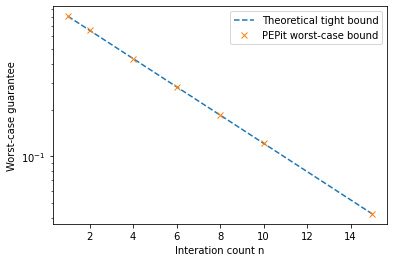

In [15]:
# Plot theoretical and PEPit (numerical) worst-case performance bounds as functions of the iteration count

plt.plot(n_list, theoretical_taus, '--', label='Theoretical tight bound')
plt.plot(n_list, pepit_taus, 'x', label='PEPit worst-case bound')

plt.semilogy()
plt.legend()
plt.xlabel('Interation count n')
plt.ylabel('Worst-case guarantee')

plt.show()

#### 3.1.2 Worst-case guarantees as functions of the step size

In [16]:
# Set the parameters
n = 1      # iteration counter
L = 1      # smoothness parameter
mu = 0.1   # strong convexity parameter

# Set a list of step-sizes to test
gammas = np.linspace(0, 2 / L, 41)


# Compute numerical and theoretical (analytical) worst-case guarantees for the each step-size
pepit_taus = list()
theoretical_taus = list()
for gamma in gammas:
    pepit_tau, theoretical_tau = wc_gradient_descent_contraction(mu=mu,
                                                                 L=L,
                                                                 gamma=gamma,
                                                                 n=n,
                                                                 verbose=verbose,
                                                                )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

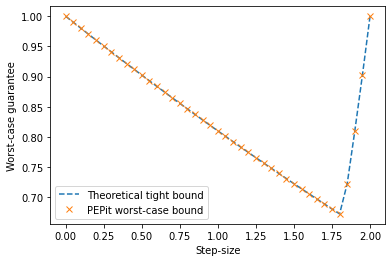

In [17]:
# Plot theoretical and PEPit (numerical) worst-case performance bounds as functions of the step-size

plt.plot(gammas, theoretical_taus, '--', label='Theoretical tight bound')
plt.plot(gammas, pepit_taus, 'x', label='PEPit worst-case bound')

plt.legend()
plt.xlabel('Step-size')
plt.ylabel('Worst-case guarantee')

plt.show()

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

### 3.2 Example 2 : An accelerated gradient method for strongly convex objectives<a class="anchor" id="example2"></a>

We consider the following convex minimization problem
\begin{equation}
f_\star \triangleq \min_x f(x),
\end{equation}
where $f$ is $L$-smooth and $\mu$-strongly convex.


The package PEPit allows to compute a worst-case guarantee for an **accelerated gradient** method (a.k.a., **fast gradient**, or **Nesterov's accelerated** method). That is, it computes the smallest possible $\tau(n, L, \mu)$ such that the following guarantee holds (for all initialization and $L$-smooth $\mu$-strongly convex function)
\begin{equation}
f(x_n) - f_\star \leqslant \tau(n, L, \mu) \left(f(x_0) - f_\star + \frac{\mu}{2}\| x_0 - x_\star\|^2_2\right),
\end{equation}
where $x_n$ is the output of the accelerated gradient method under consideration, and where $x_\star$ is the minimizer of $f$.


#### Algorithm

The accelerated gradient method under consideration is described as follows, for $t \in \{0,1, \ldots, n-1\}$
\begin{equation}
\begin{aligned}
        x_{t+1} & = y_t - \alpha \nabla f(y_t),\\
        y_{t+1} & = x_{t+1} + \beta (x_{t+1} - x_{t}),
    \end{aligned}
\end{equation}
with $\kappa = \frac{\mu}{L}$, $\alpha = \frac{1}{L}$ and $\beta = \frac{1 - \sqrt{\kappa}}{1 + \sqrt{\kappa}}$.

#### Theoretical guarantee

A known worst-case guarantee is provided by 
\begin{equation}
f(x_n) - f_\star \leqslant \left(1-\sqrt{\kappa}\right)^n \left(f(x_0) -  f(x_\star) + \frac{\mu}{2}\|x_0 - x_\star\|^2_2\right).
\end{equation}

#### Plot worst-case guarantees as functions of the iteration count

In [18]:
# Set the parameters
L = 1          # smoothness parameter
mu = 0.1       # strong convexity parameter
gamma = 1 / L  # step-size

# Set a list of iteration counter to test
n_list = np.array([1, 2, 4, 6, 8, 10, 15])


# Compute numerical and theoretical (analytical) worst-case guarantees for each iteration count
pepit_taus = list()
theoretical_taus = list()
for n in n_list:
    pepit_tau, theoretical_tau = wc_accelerated_gradient_strongly_convex(mu=mu,
                                                                         L=L,
                                                                         n=n,
                                                                         verbose=verbose,
                                                                        )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

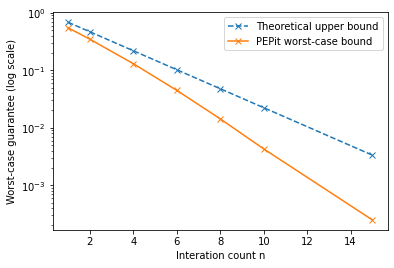

In [19]:
# Plot theoretical and PEPit (numerical) worst-case performance bounds as functions of the iteration count

plt.plot(n_list, theoretical_taus, '--x', label='Theoretical upper bound')
plt.plot(n_list, pepit_taus, '-x', label='PEPit worst-case bound')

plt.semilogy()
plt.legend()
plt.xlabel('Interation count n')
plt.ylabel('Worst-case guarantee (log scale)')

plt.show()

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

### 3.3 Example 3 : An accelerated Douglas-Rachford splitting<a class="anchor" id="example3"></a>

We consider the following composite convex minimization problem
\begin{equation}
    F_\star \triangleq \min_x \{F(x) \equiv f_1(x) + f_2(x)\},
\end{equation}
where $f_1$ is closed proper and convex, and $f_2$ is $\mu$-strongly convex and $L$-smooth. We assume access to the proximal operator of both $f_1$ and $f_2$.

The package PEPit allows to compute a worst-case guarantee for **accelerated Douglas-Rachford**. That is, it computes the smallest possible $\tau(n, L, \mu, \alpha)$ such that the following guarantee holds (for all initilization of the algorithm, and all functions satisfying the assumptions):
\begin{equation}
F(y_n) - F(x_\star) \leqslant \tau(n, L, \mu, \alpha) \| w_0 - w_\star \|^2,
\end{equation}
where $\alpha$ is a parameter of the method, and where $y_n$ is the output of the accelerated Douglas-Rachford method, where $x_\star$ is a minimizer of $F$, and $w_\star$ defined such that
\begin{equation}
x_\star = \text{prox}_{\alpha f_2}(w_\star).
\end{equation}

#### Algorithm

The accelerated Douglas-Rachford method under consideration is be described as follows, for $t \in \{0,1, \ldots, n-1\}$
\begin{equation}
    \begin{aligned}
        x_t     &= \mathrm{prox}_{\alpha f_2}(u_t), \\
        y_t     &= \mathrm{prox}_{\alpha f_1}(2x_t - u_t), \\
        w_{t+1} &= u_t +\theta (y_t - x_t), \\
        u_{t+1} &= \left\{\begin{array}{ll} w_{t+1}+\frac{t-1}{t+2}(w_{t+1}-w_t)\, & \mbox{if } t \geqslant 1,\\
                w_{t+1} & \mbox{otherwise,} \end{array} \right.
    \end{aligned}
\end{equation}

#### Theoretical guarantee

There is no known worst-case guarantee for this method beyond quadratic minimization. When the objective function is a quadratic, a worst-case **upper** bound is provided by
\begin{equation}
    F(y_n) - F_\star \leqslant  \frac{2\|w_0 - w_\star\|^2_2}{\alpha \theta(n+3)^2},
\end{equation}
when $\theta = \frac{1 - \alpha L}{1 + \alpha L}$ and $\alpha < \frac{1}{L}$.

#### Plot worst-case guarantees as functions of the iteration count

In [20]:
# Set the parameters
L = 1          # smoothness parameter
mu = 0.1       # strong convexity parameter
gamma = 1 / L  # step-size
alpha = 0.9

# Set a list of iteration counter to test
n_list = np.array([1, 2, 4, 6, 8, 10, 15])


# Compute numerical and theoretical (analytical) worst-case guarantees for each iteration count
pepit_taus = list()
theoretical_taus = list()
for n in n_list:
    pepit_tau, theoretical_tau = wc_accelerated_douglas_rachford_splitting(mu=mu,
                                                                           L=L,
                                                                           alpha=alpha,
                                                                           n=n,
                                                                           verbose=verbose,
                                                                          )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

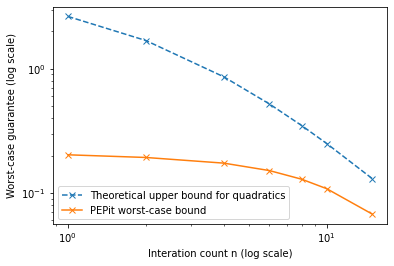

In [21]:
# Plot theoretical and PEPit (numerical) worst-case performance bounds as functions of the iteration count

plt.plot(n_list, theoretical_taus, '--x', label='Theoretical upper bound for quadratics')
plt.plot(n_list, pepit_taus, '-x', label='PEPit worst-case bound')

plt.semilogy()
plt.semilogx()
plt.legend()
plt.xlabel('Interation count n (log scale)')
plt.ylabel('Worst-case guarantee (log scale)')

plt.show()

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

### 3.4 Example 4 : point-SAGA<a class="anchor" id="example4"></a>

We consider the following finite sum minimization problem
\begin{equation}
F_\star \triangleq \min_x \left\{F(x) \equiv \frac{1}{n} \sum_{i=1}^{n} f_i(x)\right\},
\end{equation}
where $f_1, \ldots, f_n$ are $L$-smooth and $\mu$-strongly convex functions with proximal operators readily available.

The package PEPit allows to compute a tight (one-step) worst-case guarantee using a Lyapunov function for **point-SAGA**. The Lyapunov (or energy) function at a point $x$ is given by:
\begin{equation}
V(x) = \frac{1}{L \mu}\frac{1}{n} \sum_{i \leqslant n} \|\nabla f_i(x) - \nabla f_i(x_\star)\|^2_2 + \|x - x_\star\|^2_2,
\end{equation}
where $x_\star$ denotes the minimizer of $F$. The code computes the smallest possible $\tau(n, L, \mu)$ such that the guarantee
\begin{equation}
\mathbb{E}_{j_t}\Big[V\big(x^{(t+1)}_{j_t}\big)\Big] \leqslant \tau(n, L, \mu) V\left(x^{(t)}\right),
\end{equation}
is valid (for all initialization and all functions satisfying the assumptions).

#### Algorithm

At each iteration $t$, point-SAGA picks $j_t \in \{1, \ldots, n\}$ uniformly at random and performs the following updates
\begin{equation*}
    \begin{aligned}
    z_{j_t}^{(t)} &= x^{(t)} + \gamma \left(g_{j_t}^{(t)} - \frac{1}{n} \sum_i g_i^{(t)}\right),\\
    x^{(t+1)}_{j_t} &= \mathrm{prox}_{\gamma f_{j_t}} \left(z_{j_t}^{(t)}\right),\\
    g_{j_t}^{(t+1)} &= \frac{1}{\gamma}\left(z_{j_t}^{(t)} - x^{(t+1)}_{j_t}\right),
    \end{aligned}
\end{equation*}
where $\gamma=\frac{\sqrt{(n - 1)^2 + 4n\frac{L}{\mu}}}{2Ln} - \frac{\left(1 - \frac{1}{n}\right)}{2L}$ is the step size.

#### Thoeretical guarantee

A worst-case **upper** bound is provided by
\begin{equation}
\mathbb{E}_{j_t}\left[V\left(x^{(t+1)}_{j_t}\right)\right] \leqslant \frac{1}{1 + \mu\gamma} V\left(x^{(t)}\right).
\end{equation}

#### Plot worst-case guarantees as functions of the condition number

We have seen that the proof is based on a Lyapunov function. We plot the convergence rate for this Lyapunov function as a function of the condition number $\kappa = \frac{L}{\mu}$.

In [22]:
# Set the parameters
L = 1         # smoothness parameter
n = 5         # the number of functions

# Set a list of strong convexity parameter to test, given that the condition number kappa = L / mu
mus = np.logspace(-4, -1, 14)  

# Compute numerical and theoretical (analytical) worst-case guarantees for each iteration count
pepit_taus = list()
theoretical_taus = list()
for mu in mus:
    pepit_tau, theoretical_tau = wc_point_saga(L=L,
                                               mu=mu,
                                               n=n,
                                               verbose=verbose,
                                              )
    pepit_taus.append(pepit_tau)
    theoretical_taus.append(theoretical_tau)

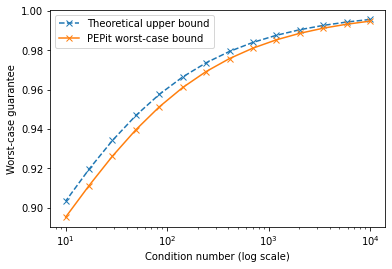

In [23]:
# Plot theoretical and PEPit (numerical) worst-case performance bounds as functions of the iteration count

plt.plot(L/mus, theoretical_taus, '--x', label='Theoretical upper bound')
plt.plot(L/mus, pepit_taus, '-x', label='PEPit worst-case bound')

plt.semilogx()
plt.legend()
plt.xlabel('Condition number (log scale)')
plt.ylabel('Worst-case guarantee')

plt.show()

<div align="right"><a href="#toc">↩ Back to TOC</a></div>